In [67]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import shap
import xgboost as xgb
import joblib

In [2]:
df = pd.read_csv('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/PS_20174392719_log.csv')

In [64]:
columns_to_drop = ['isFraud', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceOrg']
X = df.drop(columns_to_drop, axis=1)
y = df['isFraud']

#X = df_balanced.drop(columns_to_drop, axis=1)
#y = df_balanced['isFraud']

In [6]:
tscv = TimeSeriesSplit(n_splits=4)

# Using TimeSeriesSplit to extract the last split
for _, (train_val_indices, test_indices) in enumerate(tscv.split(X)):
    pass  # We're using this loop to get the final split indices

# Extract training + validation set and test set
X_train_val, X_test_final = X.iloc[train_val_indices], X.iloc[test_indices]
y_train_val, y_test_final = y.iloc[train_val_indices], y.iloc[test_indices]
# here is the final test set that we would like to see test score

In [26]:
# pipeline for Logistic Regression 
# Preprocessing Pipeline
cat_ftrs = ['type']
num_ftrs = ['amount', 'newbalanceOrig', 'newbalanceDest']

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)], remainder='passthrough')



In [68]:
# Classifier (l1 & l2)
clf = LogisticRegression()

# Pipeline with SMOTE and logistic regression
pipe = make_pipeline(preprocessor, clf)

# Hyperparameters for L1 regularization
param_grid_l1 = {
    'logisticregression__C': np.logspace(-3, 3, 7),
    'logisticregression__penalty': ['l1','l2'],
    'logisticregression__solver': ['saga'],
    'logisticregression__class_weight': ['balanced'],
    'logisticregression__max_iter': [1000]
}

# Define the TimeSeriesSplit with a fixed n_splits=4
tscv = TimeSeriesSplit(n_splits=4)

# Initialize storage for scores and models
model_time_l1 = 0

# Run L1 regularization with TimeSeriesSplit
print('L1 Regularization with TimeSeriesSplit')
start_time = time.time()

grid_l1 = GridSearchCV(pipe, param_grid=param_grid_l1, scoring='average_precision', cv=tscv, n_jobs=-1, verbose=10)
grid_l1.fit(X_train_val, y_train_val)

# Storing and printing best model parameters for the final iteration
print('Best model parameters (L1):', grid_l1.best_params_)
print("Best training score:", grid_l1.best_score_)

best_model = grid_l1.best_estimator_
y_pred = best_model.predict_proba(X_test_final)[:, 1]
test_score_l1 = average_precision_score(y_test_final, y_pred)
print('Test Score:', test_score_l1)

# Calculate precision and recall for the test set
precision_l1, recall_l1, _ = precision_recall_curve(y_test_final, y_pred)

model_time_l1 = time.time() - start_time
print("Total Logistic Regression L1 training time: {} seconds".format(model_time_l1))

joblib.dump(best_model, 'logistic_regression_model.pkl')

L1 Regularization with TimeSeriesSplit
Fitting 4 folds for each of 14 candidates, totalling 56 fits


/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_enc

Best model parameters (L1): {'logisticregression__C': 10.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Best training score: 0.13319959233401732
Test Score: 0.07872587474323073
Total Logistic Regression L1 training time: 100.50958395004272 seconds


The max_iter was reached which means the coef_ did not converge


['logistic_regression_model.pkl']

[CV 4/4; 2/14] START logisticregression__C=0.001, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, logisticregression__penalty=l2, logisticregression__solver=saga
[CV 4/4; 2/14] END logisticregression__C=0.001, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, logisticregression__penalty=l2, logisticregression__solver=saga;, score=0.175 total time=  26.9s
[CV 1/4; 7/14] START logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=saga
[CV 1/4; 7/14] END logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.138 total time=   0.1s
[CV 2/4; 7/14] START logisticregression__C=1.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregressi

In [69]:
# Classifier
clf = RandomForestClassifier()

pipe = make_pipeline(preprocessor, clf)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'randomforestclassifier__n_estimators': [25, 50, 100, 200],
    'randomforestclassifier__max_depth': [10, 20, 30, None],
    'randomforestclassifier__max_features': [None, 'sqrt'],
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}

# Initialize storage for scores and models
model_time_rf = 0

# Run L1 regularization with TimeSeriesSplit
print('Random Forest with TimeSeriesSplit')
start_time = time.time()

grid_rf = GridSearchCV(pipe, param_grid=param_grid_rf, scoring='average_precision', cv=tscv, n_jobs=-1, verbose=10)
grid_rf.fit(X_train_val, y_train_val)

# Storing and printing best model parameters for the final iteration
print('Best model parameters (RF):', grid_rf.best_params_)
print("Best training score:", grid_rf.best_score_)

best_model = grid_rf.best_estimator_
y_pred = best_model.predict_proba(X_test_final)[:, 1]
test_score_rf = average_precision_score(y_test_final, y_pred)
print('Test Score:', test_score_rf)

# Calculate precision and recall for the test set
precision_rf, recall_rf, _ = precision_recall_curve(y_test_final, y_pred)

model_time_rf = time.time() - start_time
print("Total RF training time: {} seconds".format(model_time_rf))

joblib.dump(best_model, 'RF_model.pkl')

Random Forest with TimeSeriesSplit
Fitting 4 folds for each of 64 candidates, totalling 256 fits


/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_enc

Best model parameters (RF): {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 200}
Best training score: 0.5975478205642142
Test Score: 0.7222155103247733
Total RF training time: 632.6303610801697 seconds


['RF_model.pkl']

In [70]:
from sklearn.neighbors import KNeighborsClassifier
# Classifier
clf = KNeighborsClassifier()

pipe = make_pipeline(preprocessor, clf)

# Hyperparameter grid for KNN
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [5, 10, 15, 20, 25, 30],
    'kneighborsclassifier__weights': ['distance']
}

# Initialize storage for scores and models
model_time_knn = 0

# Run L1 regularization with TimeSeriesSplit
print('KNeighborsClassifier with TimeSeriesSplit')
start_time = time.time()

grid_knn = GridSearchCV(pipe, param_grid=param_grid_knn, scoring='average_precision', cv=tscv, n_jobs=-1, verbose=10)
grid_knn.fit(X_train_val, y_train_val)

# Storing and printing best model parameters for the final iteration
print('Best model parameters (KNN):', grid_knn.best_params_)
print("Best training score:", grid_knn.best_score_)

best_model = grid_knn.best_estimator_
y_pred = best_model.predict_proba(X_test_final)[:, 1]
test_score_knn = average_precision_score(y_test_final, y_pred)
print('Test Score:', test_score_knn)

# Calculate precision and recall for the test set
precision_knn, recall_knn, _ = precision_recall_curve(y_test_final, y_pred)

model_time_knn = time.time() - start_time
print("Total KNN training time: {} seconds".format(model_time_knn))

joblib.dump(best_model, 'KNN_model.pkl')

KNeighborsClassifier with TimeSeriesSplit
Fitting 4 folds for each of 6 candidates, totalling 24 fits


/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_enc

Best model parameters (KNN): {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
Best training score: 0.12936169429698458
Test Score: 0.06297730757315889
Total KNN training time: 1.2621300220489502 seconds


['KNN_model.pkl']

In [71]:
### from xgboost import XGBClassifier

# Class weight calculation
weights = (y == 0).sum() / (1.0 * (y == 1).sum())

# Classifier
clf = XGBClassifier()

pipe = make_pipeline(preprocessor, clf)

# Hyperparameter grid for XGBoost
param_grid_xgboost = {
    "xgbclassifier__learning_rate": [0.01, 0.03],
    "xgbclassifier__n_estimators": [500,750],
    "xgbclassifier__seed": [0],
    "xgbclassifier__reg_alpha": [1e-2, 1e0, 1e2],
    "xgbclassifier__reg_lambda": [1e-2, 1e0, 1e2],  
    "xgbclassifier__colsample_bytree": [0.5, 0.9],
    "xgbclassifier__subsample": [0.66],
    "xgbclassifier__scale_pos_weight": [weights]
}

# Initialize storage for scores and models
model_time_xgboost = 0

# Run L1 regularization with TimeSeriesSplit
print('XGboost with TimeSeriesSplit')
start_time = time.time()

grid_xgboost = GridSearchCV(pipe, param_grid=param_grid_xgboost, scoring='average_precision', cv=tscv, n_jobs=-1, verbose=10)
grid_xgboost.fit(X_train_val, y_train_val)

# Storing and printing best model parameters for the final iteration
print('Best model parameters (XGboost):', grid_xgboost.best_params_)
print("Best training score:", grid_xgboost.best_score_)

best_model = grid_xgboost.best_estimator_
y_pred = best_model.predict_proba(X_test_final)[:, 1]
test_score_xgboost = average_precision_score(y_test_final, y_pred)
print('Test Score:', test_score_xgboost)

# Calculate precision and recall for the test set
precision_xgboost, recall_xgboost, _ = precision_recall_curve(y_test_final, y_pred)

model_time_xgboost = time.time() - start_time
print("Total XGboost training time: {} seconds".format(model_time_xgboost))

joblib.dump(best_model, 'XGBoost_model.pkl')

XGboost with TimeSeriesSplit
Fitting 4 folds for each of 72 candidates, totalling 288 fits


/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_enc

Best model parameters (XGboost): {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.03, 'xgbclassifier__n_estimators': 750, 'xgbclassifier__reg_alpha': 1.0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__scale_pos_weight': 54.76628151260504, 'xgbclassifier__seed': 0, 'xgbclassifier__subsample': 0.66}
Best training score: 0.6541148023648153
Test Score: 0.7356377229078097
Total XGboost training time: 1194.8957841396332 seconds


['XGBoost_model.pkl']

[CV 1/4; 1/64] START randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=None, randomforestclassifier__n_estimators=25
[CV 1/4; 1/64] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=None, randomforestclassifier__n_estimators=25;, score=0.441 total time=   2.2s
[CV 1/4; 3/64] START randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=None, randomforestclassifier__n_estimators=100
[CV 1/4; 3/64] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=None, randomforestclassifier__n_estimators=100;, score=0.464 total time=   7.8s
[CV 2/4; 4/64] START randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=None, randomforestclassifier__n_estim

In [14]:
# Combine these scores into a list
avg_scores = [test_score_l1, test_score_knn, test_score_rf, test_score_xgboost]
model_names = ["Logistic Regression", "KNN", "Random Forest", "XGBoost"]
model_times = [model_time_l1, model_time_knn, model_time_rf, model_time_xgboost]  # Run time for each model

In [15]:
avg_scores

[0.07872505194933863,
 0.06297730757315889,
 0.7128568987670701,
 0.7356377229078097]

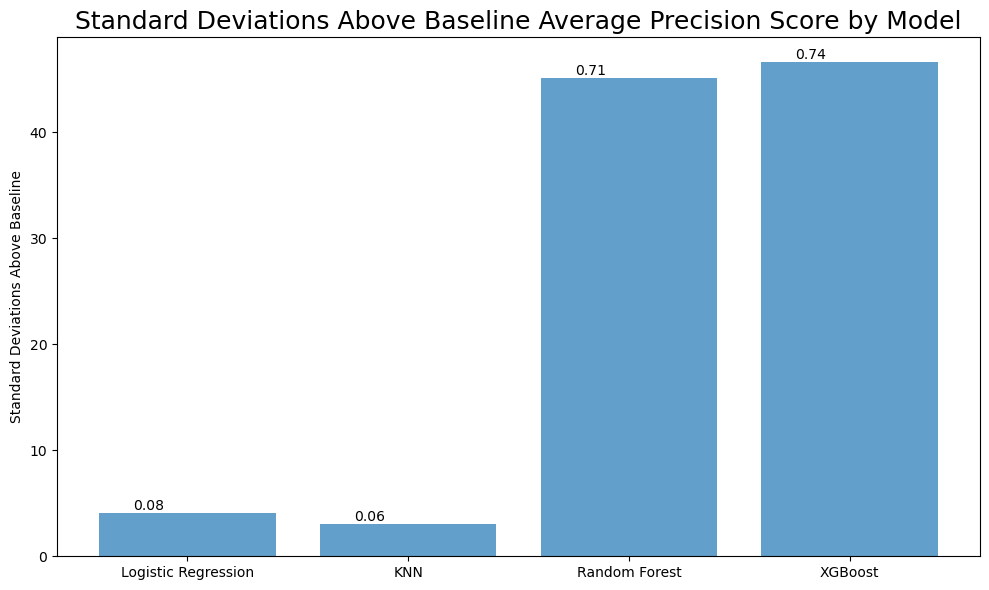

In [18]:
# Calculate standard deviation above baseline for each model
baseline_score = sum(y_test_final) / len(y_test_final)
std_devs_above_baseline = [(score - baseline_score) / baseline_score for score in avg_scores]
bar_width = 0.35  # Width of the bars
# Also add run time for each model in another bar...
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(model_names)), std_devs_above_baseline, align='center', alpha=0.7, capsize=10)
# Add test scores as text above the bars
for i, score in enumerate(std_devs_above_baseline):
    plt.text(i - bar_width/2, score, f'{avg_scores[i]:.2f}', ha='center', va='bottom')
    
plt.xticks(range(len(model_names)), model_names)
plt.ylabel('Standard Deviations Above Baseline')
plt.title('Standard Deviations Above Baseline Average Precision Score by Model', fontsize=18)

# Save the figure
plt.tight_layout()
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Result_by_Model(SD).png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
baseline_score

0.015446197315752296

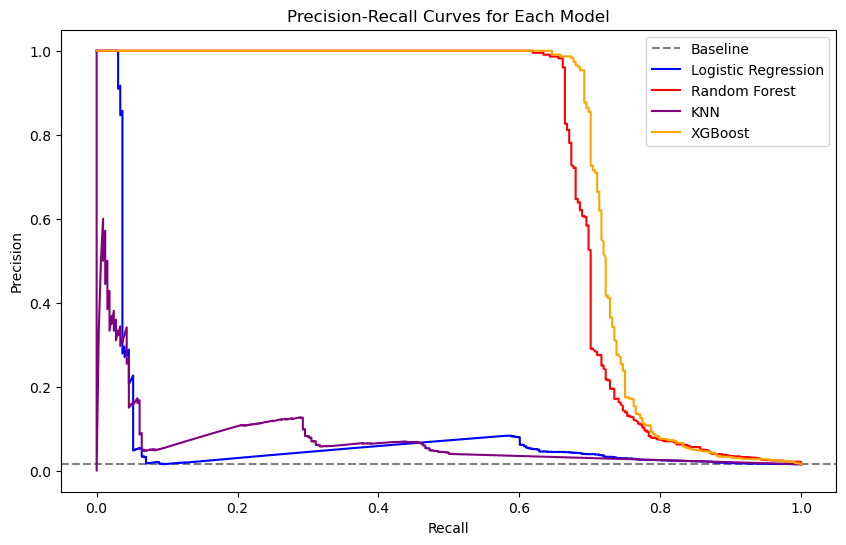

In [19]:
# Plotting precision-recall curves for each model using the best iteration
plt.figure(figsize=(10, 6))
plt.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')

plt.plot(recall_l1, precision_l1, label='Logistic Regression', color='blue')
plt.plot(recall_rf, precision_rf, label='Random Forest', color='red')
plt.plot(recall_knn, precision_knn, label='KNN', color='purple')
plt.plot(recall_xgboost, precision_xgboost, label='XGBoost', color='orange')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Model')
plt.legend()
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Precision Recall Curve.png', dpi=300, bbox_inches='tight')
plt.show()

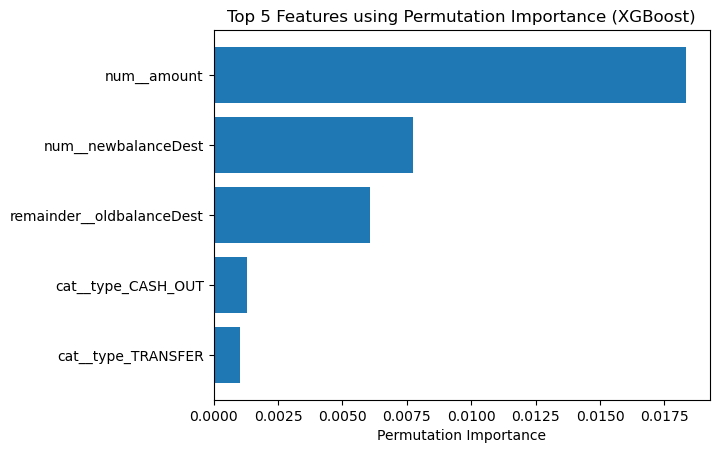

In [52]:
# Global Impoartance
# Permutation Importance
# Preprocess the test data
# Extract the best estimator from your grid search
xgb_model = grid_xgboost.best_estimator_.named_steps['xgbclassifier']

X_test_preprocessed = grid_xgboost.best_estimator_.named_steps['columntransformer'].transform(X_test_final)
transformed_feature_names = np.array(grid_xgboost.best_estimator_.named_steps['columntransformer'].get_feature_names_out())

# Calculate permutation importance
perm_importance = permutation_importance(xgb_model, X_test_preprocessed, y_test_final, n_repeats=30, random_state=0)

# Sort and plot
sorted_idx = perm_importance.importances_mean.argsort()[-5:]
plt.barh(range(5), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(5), transformed_feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Top 5 Features using Permutation Importance (XGBoost)")
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Permutation_importance(Global).png', dpi=300, bbox_inches='tight')
plt.show()

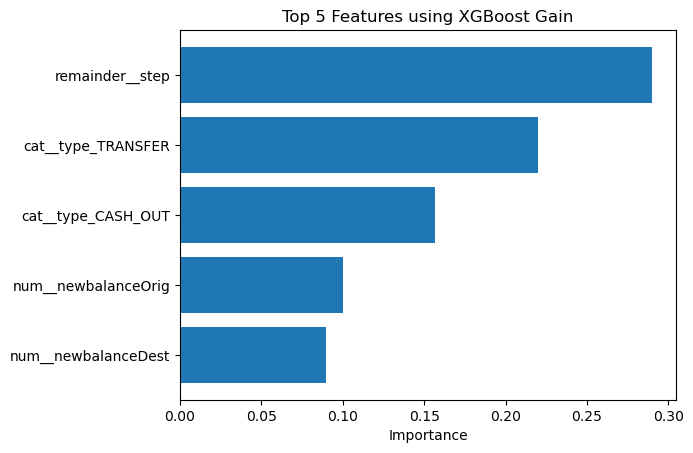

In [53]:
# XGBoost 'Gain' Feature Importance
# Gain-based feature importance

# Transform a sample of the dataset using the preprocessing part of the pipeline
sample_transformed = grid_xgboost.best_estimator_.named_steps['columntransformer'].transform(X_train_val.head())

# Get feature names after transformation
transformed_feature_names = np.array(grid_xgboost.best_estimator_.named_steps['columntransformer'].get_feature_names_out())

# Feature importances from XGBoost
feature_importances = xgb_model.feature_importances_

# Match transformed feature names with importances
importance_dict = dict(zip(transformed_feature_names, feature_importances))
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Plotting
features, importances = zip(*sorted_importances)
plt.barh(features[::-1], importances[::-1])  # Reverse order to display the most important feature at the top
plt.xlabel("Importance")
plt.title("Top 5 Features using XGBoost Gain")
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/XGBoostGain(Global).png', dpi=300, bbox_inches='tight')
plt.show()


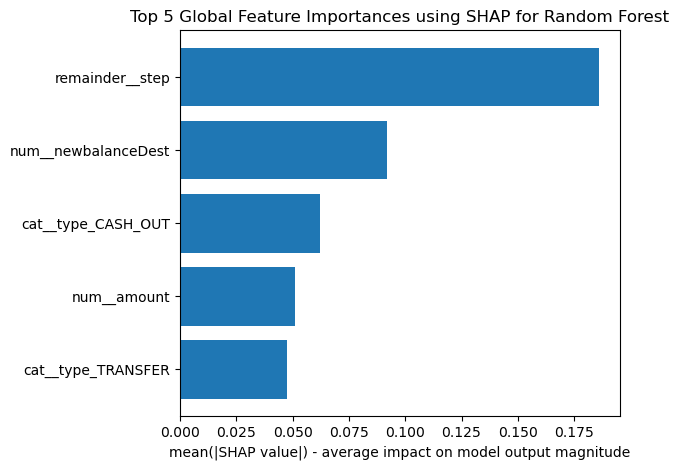

In [69]:
# Ensure X_test_preprocessed_rf is a DataFrame with the correct feature names
if not isinstance(X_test_preprocessed, pd.DataFrame):
    feature_names = grid_xgboost.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed_rf, columns=feature_names)

# Initialize the SHAP Tree Explainer with the Random Forest model
rf_model = grid_rf.best_estimator_.named_steps['randomforestclassifier']
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the preprocessed test set
shap_values = explainer.shap_values(X_test_preprocessed_rf)

# Since we have one SHAP value array per class, we sum them up to get overall importance
# Assuming binary classification and we are interested in the importance for the positive class
shap_sum = np.abs(shap_values[1]).mean(axis=0)

# Get indices of the top 5 features
indices = np.argsort(shap_sum)[-5:]

# Get top features and their SHAP values
top_features = X_test_preprocessed_rf.columns[indices]
top_shap_values = shap_sum[indices]

# Create the SHAP summary plot manually
plt.barh(top_features, top_shap_values)
plt.xlabel('mean(|SHAP value|) - average impact on model output magnitude')
plt.title('Top 5 Global Feature Importances using SHAP for Random Forest')
plt.tight_layout()  # To ensure the full labels fit in the saved figure
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/SHAP(Global).png', dpi=300, bbox_inches='tight')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


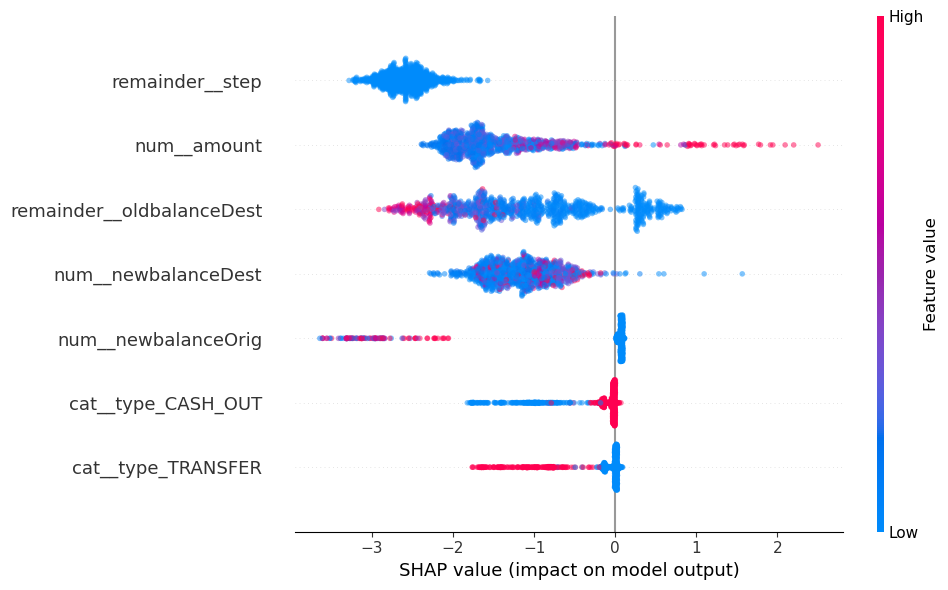

In [57]:
import shap

# Assuming you have already preprocessed your test data as X_test_preprocessed
# and you have your trained XGBoost model as xgb_model

# Create a SHAP explainer object
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values - this can be computationally intensive
shap_values = explainer(X_test_preprocessed[:1000])

# Get feature names from the preprocessor
# This assumes you have already retrieved transformed_feature_names
feature_names = transformed_feature_names

# Plot the SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test_preprocessed[:1000], feature_names=feature_names, plot_size=(10,6), alpha=0.5, show=False)

#shap.save_html('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/SHAP(Global).html', shap_html)
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/SHAP(Global).png', dpi=300, bbox_inches='tight')


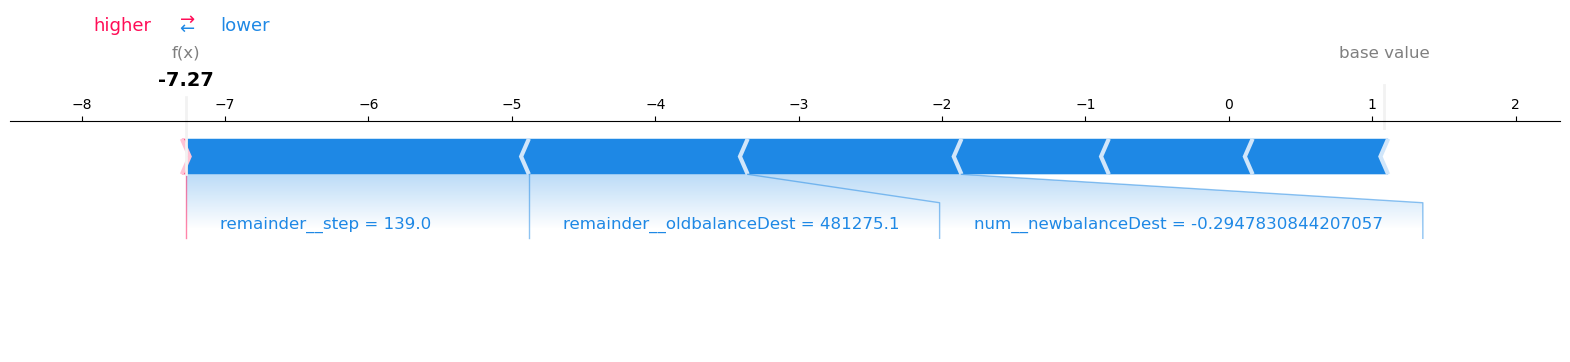

In [59]:
# Calculate SHAP values for all test instances
if not isinstance(X_test_preprocessed, pd.DataFrame):
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_feature_names)

# Initialize the SHAP explainer (assuming xgboost_model is already defined as your XGBoost best estimator)
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for all test instances
shap_values = explainer.shap_values(X_test_preprocessed)

# Select a single instance to examine
instance_index = 0  # You can change this index to look at other instances
instance = X_test_preprocessed.iloc[instance_index]
instance_shap_values = shap_values[instance_index]

# Plot SHAP values for the selected instance
shap.initjs()  # Required for visualizations in Jupyter notebooks if applicable
force_plot = shap.force_plot(
    explainer.expected_value,  # Base value
    instance_shap_values,      # SHAP values for the instance
    instance,                  # The instance itself
    feature_names=transformed_feature_names,  # Feature names
    matplotlib=True            # Use matplotlib for plotting instead of default JS
)
plt.show()

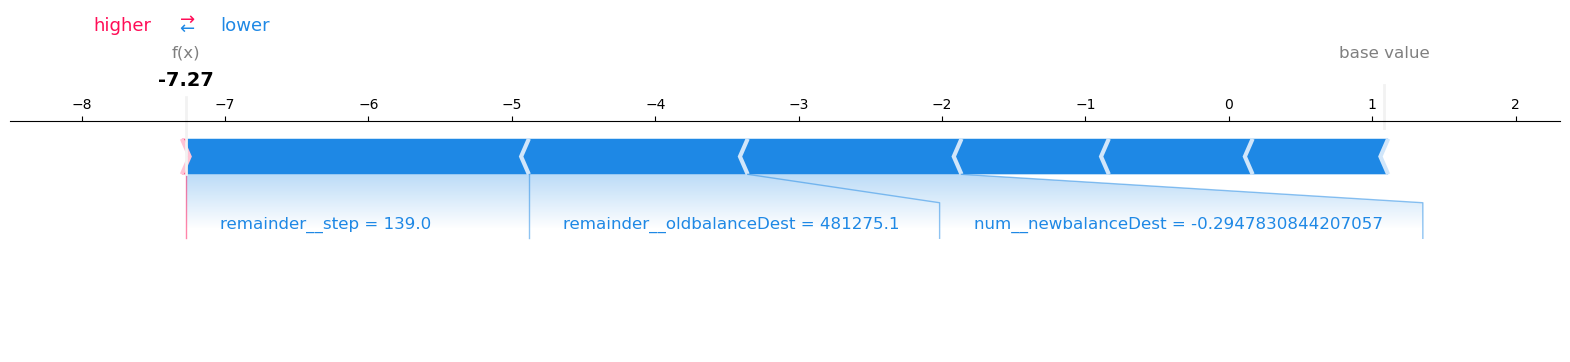

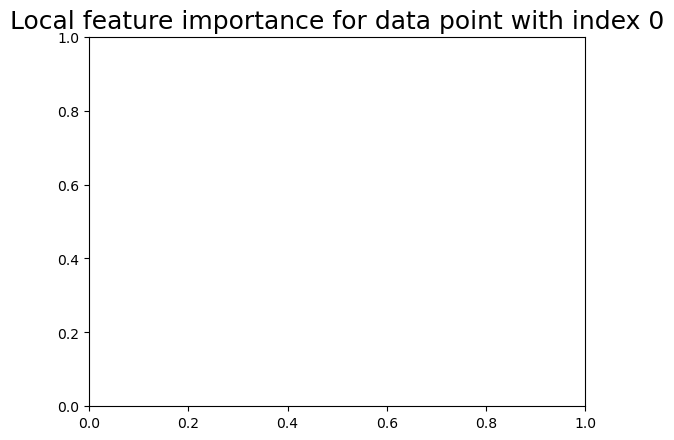

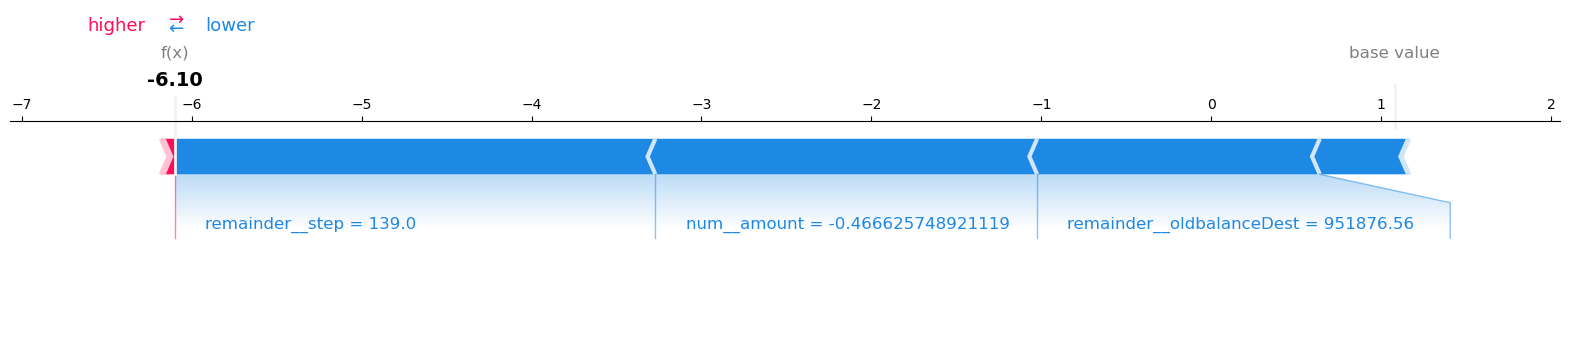

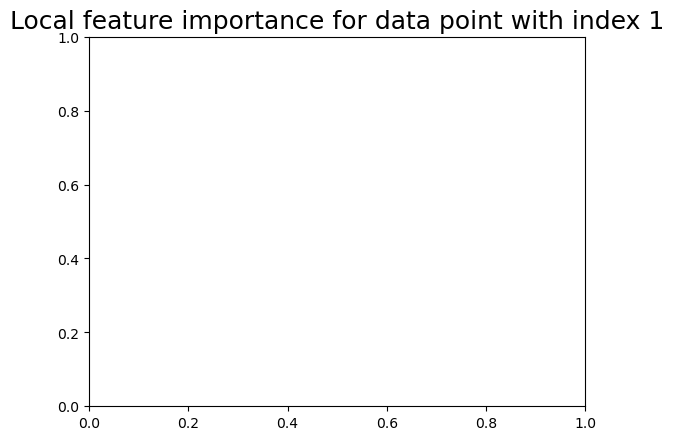

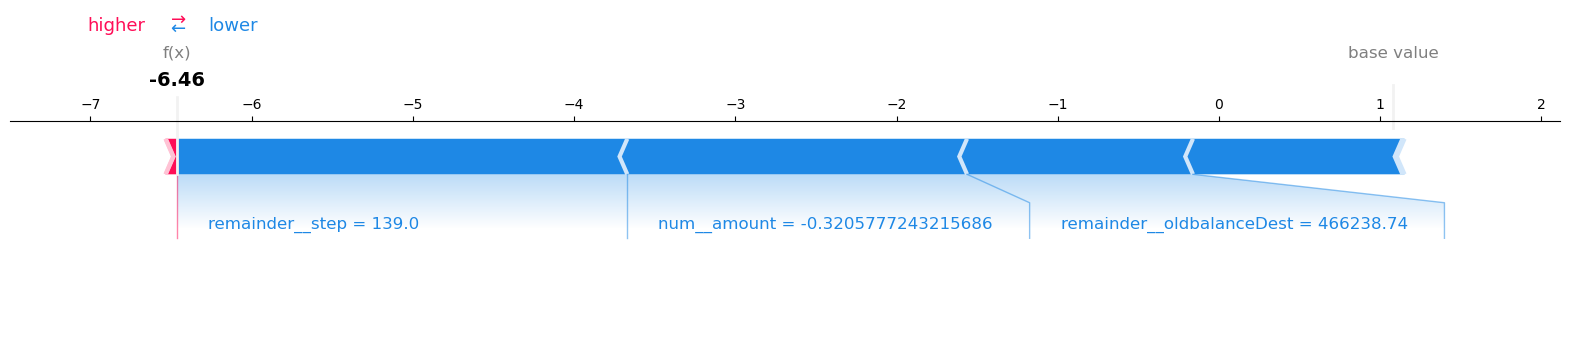

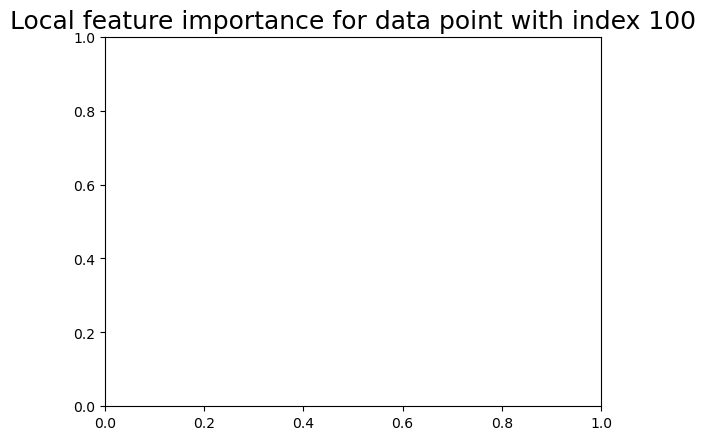

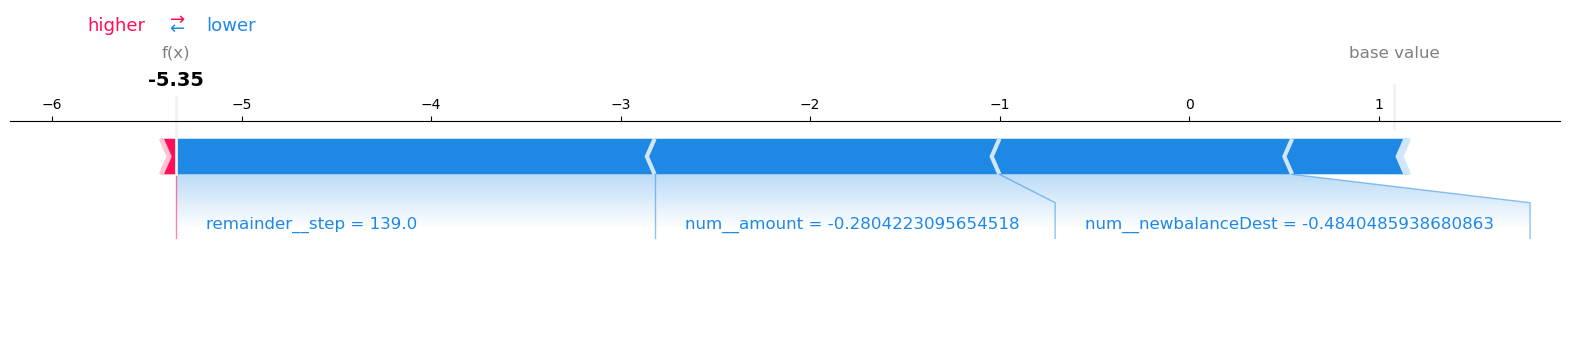

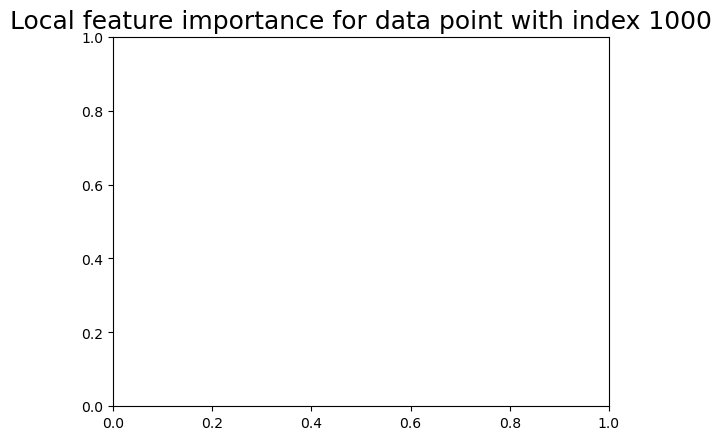

In [63]:
selected_instances = [0, 1, 100, 1000]
shap_values_selected = explainer.shap_values(X_test_preprocessed.iloc[selected_instances])

# Initialize JS visualization in Jupyter, if applicable
shap.initjs()

# Loop through the selected instances and their corresponding SHAP values
for i, instance_index in enumerate(selected_instances):
    # Plot SHAP force plot using matplotlib
    shap.force_plot(
        explainer.expected_value,  # Base value
        shap_values_selected[i],   # SHAP values for the instance
        X_test_preprocessed.iloc[instance_index],  # The instance itself
        feature_names=transformed_feature_names,  # Feature names
        matplotlib=True  # Use matplotlib for plotting instead of default JS
    )
    plt.title(f"Local feature importance for data point with index {instance_index}", size=18)
    plt.show()

In [60]:
shap_html = shap.force_plot(
    explainer.expected_value,  # Base value
    instance_shap_values,      # SHAP values for the instance
    instance,                  # The instance itself
    feature_names=feature_names,  # Feature names
    show=False                 # Do not show the plot immediately
)

# Save the plot to an HTML file
shap.save_html('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/SHAP_Local(XGBoost).html', shap_html)